# Extensions
Notebook designed to run extension experiments, these experiments include
-	Power spectrum plots
-	Perform inference for different clipping values

First, we want to run HMC for different values of $l_{max}$ on the full dataset, just like we did to produce Figure 7 in the original paper. This time our goal is to save the samples and their respective diagnostics, so that we can work on any other potential extensions.


In [2]:
import jax
import jax.numpy as jnp
import numpyro
from numpyro.infer import NUTS, MCMC, Predictive
from numpyro import handlers
from numpyro.diagnostics import summary, autocorrelation
import numpyro.distributions as dist
from src.models.vsh_model import*
from src.models.configuration import*
from src.data.data_utils import*
from src.save_load_pkl.save_load import*
import gc

/root/Document/Gaia_Project/Gaia_EDR3/gaia_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/Document/Gaia_Project/Gaia_EDR3/src/models/vsh_model.py:93: SyntaxWarning: invalid escape sequence '\d'
  """
/root/Document/Gaia_Project/Gaia_EDR3/src/models/vsh_model.py:144: SyntaxWarning: invalid escape sequence '\d'
  """
/root/Document/Gaia_Project/Gaia_EDR3/src/models/vsh_model.py:203: SyntaxWarning: invalid escape sequence '\d'
  """


In [3]:
df = load_filtered_qso_df() # load data
angles, obs, error = config_data(df)

In [ ]:
def chi2_jit(angles, obs, error, theta, lmax):
    return least_square(angles, obs, error, theta, lmax=lmax, grid=False)
chi2_jit = jit(chi2_jit, static_argnames=['lmax'])
def model_for_HMC(angles, obs, error, lmax):
    total_params = count_vsh_coeffs(lmax)

    # Prior on all VSH coefficients (both toroidal and spheroidal)
    theta = numpyro.sample("theta", dist.Normal(0.0, 1.0).expand([total_params]))
    # Least-squares residuals: we assume Gaussian-distributed residuals
    chi2_val = chi2_jit(angles, obs, error, theta, lmax=lmax)

    # The log-likelihood is proportional to -0.5*chi^2
    numpyro.factor("likelihood", -0.5*chi2_val)

In [5]:
n_s = 5000 # number of samples
n_warmup = 2000 #  number of warmups
n_chains = 6 # numbe of chains

In [ ]:
rng_key = jax.random.key(0)

kernel = NUTS(model_for_HMC, target_accept_prob=0.75) # this is to make sure acceptance does not exceed 90%

posterior_samples = [] # collect posterior samples based on l
iat_values = []
for l in range(1, 8):
    print(f'l = {l}')
    # Run sampling algoeithm (HMC)
    mcmc = MCMC(kernel, num_warmup=n_warmup, num_samples=n_s, num_chains=n_chains, chain_method='sequential', progress_bar=True)
    mcmc.run(rng_key, angles = angles, obs = obs, error = error, lmax=l)
    ps = mcmc.get_samples()
    posterior_samples.append(ps)

    diagnostics = summary(mcmc.get_samples(group_by_chain=True))
    n_eff = diagnostics['theta']['n_eff']
    iat = estimate_iat(n_s, n_chains, n_eff, index=[1,4,5])
    iat_values.append(iat)
    print(f'Autocorrelation length estimate: {iat}')

    r_hats = diagnostics['theta']['r_hat']
    avg_r_hat = np.sum(r_hats) / len(r_hats)
    print("Average r_hat:", avg_r_hat)

    divergences = mcmc.get_extra_fields()["diverging"]  # shape: (num_samples * num_chains,)
    num_divergences = divergences.sum()
    print("Number of divergences:", num_divergences)

    # == Save results ==
    save_pickle(f'lmax_{l}', posterior_samples, dir = 'hmc_samples/posterior_samples')
    save_pickle(f'lmax_{l}', diagnostics, dir = 'hmc_samples/diagnostic_hmc')

    # Free memory after each iteration
    del mcmc
    gc.collect()
    jax.clear_caches()


# Power Spectral Density (PSD) for Real-Valued VSH Coefficients

To compute the **power spectra** from the Vector Spherical Harmonic (VSH) expansion, use the following formulas for each multipole $l$:

#### Toroidal Power Spectrum $C_l^{T}$

$$
C_l^{T} = \frac{1}{2l + 1} \left( t_{l0}^2 + 2 \sum_{m=1}^{l} \left[ \left( t_{lm}^{\mathfrak{R}} \right)^2 + \left( t_{lm}^{\mathfrak{I}} \right)^2 \right] \right)
$$

#### Spheroidal Power Spectrum $C_l^{S}$

$$
C_l^{S} = \frac{1}{2l + 1} \left( s_{l0}^2 + 2 \sum_{m=1}^{l} \left[ \left( s_{lm}^{\mathfrak{R}} \right)^2 + \left( s_{lm}^{\mathfrak{I}} \right)^2 \right] \right)
$$

These give the **toroidal** and **spheroidal** angular power spectra, analogous to $C_l^B$ and $C_l^E$ in CMB polarisation analysis.

One can then plot $C_l^T$ and $C_l^S$ versus $l$ to visualise how the power in your vector field is distributed across angular scales.

In [6]:
cts = []
css = []

for idx in range(1,8):
    # Load samples and respective diagnostics
    post_sample = load_pickle(f'lmax_{idx}', dir = 'hmc_samples/posterior_samples')[0]
    diagnostics = load_pickle(f'lmax_{idx}', dir = 'hmc_samples/diagnostic_hmc')
    n_eff = diagnostics['theta']['n_eff']
    iat = estimate_iat(n_s, n_chains, n_eff)

    # Perform respective thinning
    sample = post_sample['theta'][::iat]

    # Compute PSD samples
    ct, cs = psd_vsh_coeff(sample, idx)

    # Collect PSD samples
    cts.append(ct)
    css.append(cs)

PSD violin plot for toroidal coefficients:


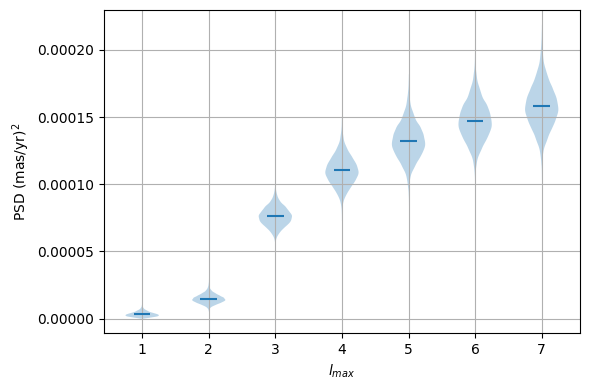

PSD violin plot for spheroidal coefficients:


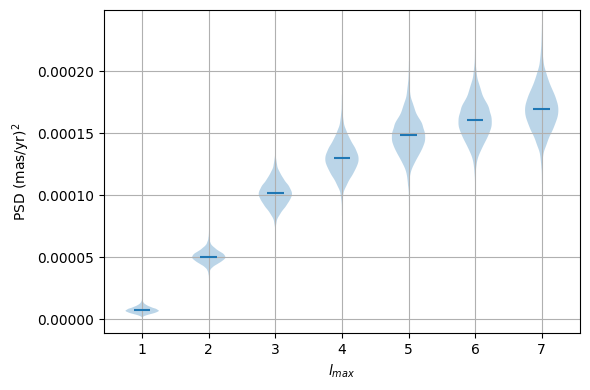

In [7]:
import matplotlib.pyplot as plt

print('PSD violin plot for toroidal coefficients:')
fig, ax = plt.subplots(figsize=(6, 4))
parts = ax.violinplot(cts, showmeans=True, showextrema=False)
ax.set_xlabel(r'$l_{max}$')
ax.set_ylabel(r'PSD (mas/yr)$^2$')
ax.grid()
plt.tight_layout()
plt.savefig("plots/extension_plots/psd_t_coeff.png", dpi=300, bbox_inches='tight')
plt.show()
print('PSD violin plot for spheroidal coefficients:')
fig, ax = plt.subplots(figsize=(6, 4))
parts = ax.violinplot(css, showmeans=True, showextrema=False)
ax.set_xlabel(r'$l_{max}$')
ax.set_ylabel(r'PSD (mas/yr)$^2$')
ax.grid()
plt.tight_layout()
plt.savefig("plots/extension_plots/psd_s_coeff.png", dpi=300, bbox_inches='tight')
plt.show()


# Repeating Analysis With Different $\kappa$
In this part we want to test how outliers and different clipping stegths affect the overall results.


In [ ]:
from src.data.clip_data import*
import jax
import jax.numpy as jnp
import numpyro
from numpyro.infer import NUTS, MCMC, Predictive
from numpyro import handlers
from numpyro.diagnostics import summary, autocorrelation
import numpyro.distributions as dist
from src.models.vsh_model import*
from src.models.configuration import*
from src.data.data_utils import*
from src.save_load_pkl.save_load import*


In [ ]:
df = load_qso_dataframe() # load data
angles, obs, error = config_data(df)

In [ ]:
lmax = 3
total_params = count_vsh_coeffs(lmax)
theta_init = jnp.zeros(total_params)

keeps = []
kappas = [2.0, 4.0]

for kappa in kappas:

    _, keep = least_square_clip(angles, obs, error, theta_init, kappa=kappa, max_iter=20)
    keeps.append(keep)

In [ ]:
for i, mask in enumerate(keeps):
    save_pickle(f'mask_{int(kappas[i])}', mask, dir = 'outlier_mask')

In [ ]:
# Load masks
mask_2 = load_pickle('mask_2', dir = 'outlier_mask')
mask_4 = load_pickle('mask_4', dir = 'outlier_mask')
df = load_qso_dataframe() # load data

# Filter data according to different maskes
df_mask_2 = df.loc[np.array(mask_2)]
df_mask_4 = df.loc[np.array(mask_4)]

Run HMC

In [ ]:
def chi2_jit(angles, obs, error, theta, lmax):
    return least_square(angles, obs, error, theta, lmax=lmax, grid=False)
chi2_jit = jit(chi2_jit, static_argnames=['lmax'])

In [ ]:
def model_for_HMC(angles, obs, error, lmax):
    total_params = count_vsh_coeffs(lmax)

    # Prior on all VSH coefficients (both toroidal and spheroidal)
    theta = numpyro.sample("theta", dist.Normal(0.0, 1.0).expand([total_params]))
    # Least-squares residuals: we assume Gaussian-distributed residuals
    chi2_val = chi2_jit(angles, obs, error, theta, lmax=lmax)

    # The log-likelihood is proportional to -0.5*chi^2
    numpyro.factor("likelihood", -0.5*chi2_val)

n_s = 5000 # number of samples
n_warmup = 2000 #  number of warmups
n_chains = 8 # numbe of chains

rng_key = jax.random.key(0)
kernel = NUTS(model_for_HMC, target_accept_prob=0.75) # this is to make sure acceptance does not exceed 90%

1. Clipping value used is $\kappa=2.0$

In [ ]:
angles, obs, error = config_data(df_mask_2)
mcmc2 = MCMC(kernel, num_warmup=n_warmup, num_samples=n_s, num_chains=n_chains, chain_method='sequential', progress_bar=True)
mcmc2.run(rng_key, angles = angles, obs = obs, error = error, lmax=3)
ps = mcmc2.get_samples()

diagnostics = summary(mcmc2.get_samples(group_by_chain=True))
n_eff = diagnostics['theta']['n_eff']
iat = estimate_iat(n_s, n_chains, n_eff, index=[1,4,5])
print(f'Autocorrelation length estimate: {iat}')

r_hats = diagnostics['theta']['r_hat']
avg_r_hat = np.sum(r_hats) / len(r_hats)
print("Average r_hat:", avg_r_hat)

divergences = mcmc2.get_extra_fields()["diverging"]  # shape: (num_samples * num_chains,)
num_divergences = divergences.sum()
print("Number of divergences:", num_divergences)

# == Save results ==
save_pickle(f'sample', ps, dir = 'hmc_samples/extension/mask2')
save_pickle(f'diagnostic', diagnostics, dir = 'hmc_samples/extension/mask2')

In [ ]:
cov_m = cov_matrix_hmc(ps['theta'][::iat], indices=[4,5,1])
result = jnp.mean(ps['theta'], axis = 0)
params = [result[1], result[4], result[5]]

summary, v_vec, v_Sigma, corr_eq = vsh_vector_summary(params, cov_m)
summary_gal, v_vec_gal, v_Sigma_gal, corr_gal = vsh_vector_summary_galactic(v_vec, v_Sigma)

lb_summary_ = lb_summary(v_vec_gal, v_Sigma_gal)
ra_dec_summary_ = ra_dec_summary(v_vec, v_Sigma)

print('Results with kappa=2:')
print_summary(summary, title='Result, Equatorial Coordinates')
print_summary(ra_dec_summary_)
print('')
print_summary(summary_gal, title='Results, Galactic Coordinates')
print_summary(lb_summary_)

2. Clipping value used $\kappa=4$

In [ ]:
angles, obs, error = config_data(df_mask_4)
mcmc4 = MCMC(kernel, num_warmup=n_warmup, num_samples=n_s, num_chains=n_chains, chain_method='sequential', progress_bar=True)
mcmc4.run(rng_key, angles = angles, obs = obs, error = error, lmax=3)
ps = mcmc4.get_samples()

diagnostics = summary(mcmc4.get_samples(group_by_chain=True))
n_eff = diagnostics['theta']['n_eff']
iat = estimate_iat(n_s, n_chains, n_eff, index=[1,4,5])
print(f'Autocorrelation length estimate: {iat}')

r_hats = diagnostics['theta']['r_hat']
avg_r_hat = np.sum(r_hats) / len(r_hats)
print("Average r_hat:", avg_r_hat)

divergences = mcmc4.get_extra_fields()["diverging"]  # shape: (num_samples * num_chains,)
num_divergences = divergences.sum()
print("Number of divergences:", num_divergences)

# == Save results ==
save_pickle(f'sample', ps, dir = 'hmc_samples/extension/mask4')
save_pickle(f'diagnostic', diagnostics, dir = 'hmc_samples/extension/mask4')


In [ ]:
cov_m = cov_matrix_hmc(ps['theta'][::iat], indices=[4,5,1])
result = jnp.mean(ps['theta'], axis = 0)
params = [result[1], result[4], result[5]]

summary, v_vec, v_Sigma, corr_eq = vsh_vector_summary(params, cov_m)
summary_gal, v_vec_gal, v_Sigma_gal, corr_gal = vsh_vector_summary_galactic(v_vec, v_Sigma)

lb_summary_ = lb_summary(v_vec_gal, v_Sigma_gal)
ra_dec_summary_ = ra_dec_summary(v_vec, v_Sigma)

print('Results with kappa=4:')
print_summary(summary, title='Result, Equatorial Coordinates')
print_summary(ra_dec_summary_)
print('')
print_summary(summary_gal, title='Results, Galactic Coordinates')
print_summary(lb_summary_)


3. Full dataset

In [ ]:
angles, obs, error = config_data(df)
mcmc_full = MCMC(kernel, num_warmup=n_warmup, num_samples=n_s, num_chains=n_chains, chain_method='sequential', progress_bar=True)
mcmc_full.run(rng_key, angles = angles, obs = obs, error = error, lmax=3)
ps = mcmc_full.get_samples()


diagnostics = summary(mcmc_full.get_samples(group_by_chain=True))
n_eff = diagnostics['theta']['n_eff']
iat = estimate_iat(n_s, n_chains, n_eff, index=[1,4,5])

print(f'Autocorrelation length estimate: {iat}')

r_hats = diagnostics['theta']['r_hat']
avg_r_hat = np.sum(r_hats) / len(r_hats)
print("Average r_hat:", avg_r_hat)

divergences = mcmc_full.get_extra_fields()["diverging"]  # shape: (num_samples * num_chains,)
num_divergences = divergences.sum()
print("Number of divergences:", num_divergences)

# == Save results ==
save_pickle(f'sample', ps, dir = 'hmc_samples/extension/full_data')
save_pickle(f'diagnostic', diagnostics, dir = 'hmc_samples/extension/full_data')


In [ ]:
cov_m = cov_matrix_hmc(ps['theta'][::iat], indices=[4,5,1])
result = jnp.mean(ps['theta'], axis = 0)
params = [result[1], result[4], result[5]]

summary, v_vec, v_Sigma, corr_eq = vsh_vector_summary(params, cov_m)
summary_gal, v_vec_gal, v_Sigma_gal, corr_gal = vsh_vector_summary_galactic(v_vec, v_Sigma)

lb_summary_ = lb_summary(v_vec_gal, v_Sigma_gal)
ra_dec_summary_ = ra_dec_summary(v_vec, v_Sigma)

print('Results on full dataset:')
print_summary(summary, title='Result, Equatorial Coordinates')
print_summary(ra_dec_summary_)
print('')
print_summary(summary_gal, title='Results, Galactic Coordinates')
print_summary(lb_summary_)
